In [1]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
print("Torch version:", torch.__version__)

Torch version: 2.0.1


## Load VAE

In [2]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

from model import VAE
vae = VAE().to(DEVICE)

to_tensor = transforms.ToTensor()

vae_transform = transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

vae.load_state_dict(torch.load("train_results/model_weights_final.pth"))

dummy input shape  torch.Size([4096])


<All keys matched successfully>

In [3]:
def apply_vae(img, model_vae):
    img_vae = model_vae(vae_transform(img))[0]
    return img_vae.detach()

## Load CLIP Loss

In [4]:
class CustomCLIPSimilarity(torch.nn.Module):

    def __init__(self, clip_model="ViT-B/32", checkpoint=None):#, resize=224):
        super(CustomCLIPSimilarity, self).__init__()
        self.model, clip_preprocess = clip.load(clip_model, device="cuda", jit=False)
        self.model.eval()

        if checkpoint is not None:
            # source: https://github.com/openai/CLIP/issues/83
            ckpt = torch.load(checkpoint)
            self.model.load_state_dict(ckpt)
    
        # Remove from the CLIP preprocessor the PIL related operations
        self.preprocess = transforms.Compose([
                clip_preprocess.transforms[0],
                clip_preprocess.transforms[1],
                clip_preprocess.transforms[4]
        ])

    def forward(self, image, text, crop=True):
        image = self.preprocess(image) 
        
        image_features = self.model.encode_image(image)
        text_features = self.model.encode_text(text)
        
        similarity = torch.nn.functional.cosine_similarity(image_features, text_features)*100

        return similarity

## Load Data

In [5]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_json("dataset/polyhaven.json")

In [6]:
train = labels
train.sort_values(by="name", ascending=True, inplace=True)

In [7]:
image_folder = datasets.ImageFolder("dataset/polyhaven_clip",transform=to_tensor) 

In [8]:
## Create datasets
class PolyHaven(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption': " ".join(caption_idx)}
        
    def __len__(self):
        return len(self.captions)
    
dataset = PolyHaven(train.caption.values.tolist(), image_folder)
len(dataset)

477

In [9]:
## create dataloaders
BATCH_SIZE  =  1
TEST_SPLIT  = .3
RANDOM_SEED = 128#42

dataset_size = train.shape[0]
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT * dataset_size))
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)

_, val_indices = indices[split:], indices[:split]

valid_sampler = SubsetRandomSampler(val_indices)
ts_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

## Evaluation code

In [10]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

vae.eval()
vae.requires_grad_(False)

def evaluate(test_dataloader, clip_similarity, use_vae=False):

    tot_batches = 0
    tot_similarity = 0
    
    for data in tqdm(test_dataloader):
        if use_vae == True:
            img_batch=apply_vae(data['image'].to(DEVICE), vae)
        else: 
            img_batch=data['image'].to(DEVICE)

        captions_batch = clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        
        with torch.no_grad():
            tot_similarity += clip_similarity(img_batch, captions_batch)
        tot_batches +=1

        del captions_batch
        del data
        torch.cuda.empty_cache()

    return (tot_similarity/tot_batches).cpu().item()
        

## Running the Evaluation

In [11]:
results = {}
clip_sim = None

In [12]:
if clip_sim in locals():
    del clip_sim
    torch.cuda.empty_cache()


clip_sim = CustomCLIPSimilarity(clip_model="ViT-B/32")

results["baseline_no_vae"] = evaluate(test_dataloader=ts_dl, clip_similarity=clip_sim, use_vae=None)

  0%|          | 0/143 [00:00<?, ?it/s]

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/c

In [13]:
if clip_sim in locals():
    del clip_sim
    torch.cuda.empty_cache()


clip_sim = CustomCLIPSimilarity(clip_model="ViT-B/32")

results["baseline_vae"] = evaluate(test_dataloader=ts_dl, clip_similarity=clip_sim, use_vae=True)

  0%|          | 0/143 [00:00<?, ?it/s]

In [14]:
if clip_sim in locals():
    del clip_sim
    torch.cuda.empty_cache()

clip_loss = CustomCLIPSimilarity(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt")
results["ft_polyhaven_no_vae"] = evaluate(test_dataloader=ts_dl, clip_similarity=clip_sim, use_vae=False)


  0%|          | 0/143 [00:00<?, ?it/s]

In [15]:
if clip_sim in locals():
    del clip_sim
    torch.cuda.empty_cache()

clip_loss = CustomCLIPSimilarity(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt")
results["ft_polyhaven_vae"] = evaluate(test_dataloader=ts_dl, clip_similarity=clip_sim, use_vae=True)


  0%|          | 0/143 [00:00<?, ?it/s]

In [16]:
if clip_sim in locals():
    del clip_sim
    torch.cuda.empty_cache()

clip_loss = CustomCLIPSimilarity(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_vae.pt")
results["ft_vae_no_vae"] = evaluate(test_dataloader=ts_dl, clip_similarity=clip_sim, use_vae=False)


  0%|          | 0/143 [00:00<?, ?it/s]

In [17]:
if clip_sim in locals():
    del clip_sim
    torch.cuda.empty_cache()

clip_loss = CustomCLIPSimilarity(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_vae.pt")
results["ft_vae_vae"] = evaluate(test_dataloader=ts_dl, clip_similarity=clip_sim, use_vae=True)


  0%|          | 0/143 [00:00<?, ?it/s]

## Results

#### Code

In [19]:
def show_finetune_scores(results):

    import matplotlib.pyplot as plt
    import numpy as np

    models = ['Baseline ViT-B/32', 'PolyHaven Finetune', 'VAE Finetune']
    scores_polyhaven = [round(results["baseline_no_vae"],3), round(results["ft_polyhaven_no_vae"],3), round(results["ft_vae_no_vae"],3)]
    scores_vae = [round(results["baseline_vae"],3), round(results["ft_polyhaven_vae"],3),round(results["ft_vae_vae"],3)]

    bar_width = 0.35
    index = np.arange(len(models))

    plt.bar(index, scores_polyhaven, bar_width, label='PolyHaven Images', alpha=0.75, color='blue')
    plt.bar(index + bar_width, scores_vae, bar_width, label='VAE Images', alpha=0.75, color='green')

    plt.xlabel('Model')
    plt.ylabel('Scores')
    plt.title('Scores by Model and Dataset')
    plt.xticks(index + bar_width / 2, models)
    plt.legend(loc='lower right')

    for i, val in enumerate(scores_polyhaven):
        if val == max(scores_polyhaven):
            plt.text(i, val + 0.1, str(val)+"%", ha='center', va='bottom', color='red', fontsize=8)
        else:
            plt.text(i, val + 0.1, str(val)+"%", ha='center', va='bottom', color='black', fontsize=8)

    for i, val in enumerate(scores_vae):
        if val == max(scores_vae):
            plt.text(i + bar_width, val + 0.1, str(val)+"%", ha='center', va='bottom', color='red', fontsize=8)
        else:
            plt.text(i + bar_width, val + 0.1, str(val)+"%", ha='center', va='bottom', color='black', fontsize=8)

    plt.show()


### Visualization

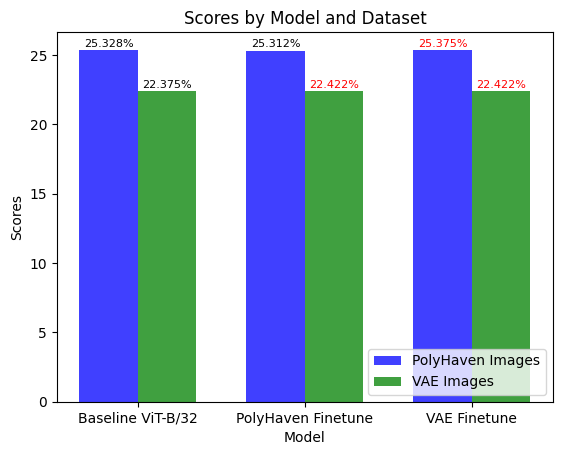

In [21]:
show_finetune_scores(results)